# Wstępna obróbka

In [75]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
dane = pd.read_csv('cervical-cancer_csv.csv')

# usuwanie kolumn
dane = dane.drop(['STDs:cervical condylomatosis', 
         'STDs:vaginal condylomatosis', 
         'STDs:pelvic inflammatory disease', 
         'STDs:genital herpes',
         'STDs:molluscum contagiosum',
         'STDs:AIDS',
         'STDs:Hepatitis B',
         'STDs:HPV', 'Dx:CIN'], axis=1)

# uzupełnianie braków i kodowanie zmiennych kategorycznych
def column_nodata(df, column_name):
    df[column_name + "_null"] = df[column_name].apply(lambda x: 1 if pd.isnull(x) else 0)
    df[column_name] = df[column_name].fillna(0)

def replace_in_column(df, column_name, src, dst):
    df[column_name] = df[column_name].replace(to_replace=src, value=dst)

replace_in_column(dane, 'STDs (number)', [3, 4], 2)
replace_in_column(dane, 'STDs: Number of diagnosis', [2,3], 1)

nodata_categories = [
    'Smokes',
    'Hormonal Contraceptives',
    'IUD',
    'STDs',
    'STDs (number)',
    'STDs:condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:HIV'
]

for category in nodata_categories:
    column_nodata(dane, category)
    
dane = pd.concat([dane, pd.get_dummies(dane['STDs (number)'], prefix='STDs_')],axis=1)
dane.drop(['STDs (number)'],axis=1, inplace=True)

# standaryzacja
numerical = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 
            'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs: Time since first diagnosis',
            'STDs: Time since last diagnosis']

scaler = StandardScaler() 
dane_scaled = scaler.fit_transform(dane[numerical])
d2 = pd.DataFrame(dane_scaled, columns = numerical)
dane[numerical] = d2[numerical]

# stworzenie jednego targetu
targets = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
def has_cancer(row):
    for target in targets:
        if row[target] == 1:
            return 1
    return 0

dane['cancer'] = dane.apply(lambda row: has_cancer(row), axis=1)
dane = dane.drop(targets, axis=1)

# Ujednolicone funkcje dla wszystkich modeli

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# podzial zbioru na treningowy i testowy
def default_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=2137)

# scoring
def scoring(y_test, y_predicted):
    print("ACC = ", accuracy_score(y_test, y_predicted))
    print("PREC = ", precision_score(y_test, y_predicted))
    print("RECALL = ", recall_score(y_test, y_predicted))
    print("F1 = ", f1_score(y_test, y_predicted))
    print("FPR = ", roc_auc_score(y_test, y_predicted))

# wyodrebnienie y
def extract_y(data):
    y = data[["cancer"]]
    return data.drop(["cancer"], axis=1), y

# Las losowy

In [10]:
# przygotowanie danych
X, y = extract_y(dane)
X = X.fillna(0)

X_train, X_test, y_train, y_test = default_split(X, y)
print(X.shape, X_train.shape, X_test.shape)

(835, 34) (668, 34) (167, 34)


In [106]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=10000,
                                  max_depth=75,
                                  min_samples_split = 2,
                                  max_features = 34,
                                  random_state=0,
                                  n_jobs = -1)
model_rf.fit(X_train, y_train)
y_predicted = model_rf.predict(X_test)
scoring(y_test, y_predicted)

ACC =  0.8323353293413174
PREC =  0.3333333333333333
RECALL =  0.037037037037037035
F1 =  0.06666666666666667
FPR =  0.5113756613756614


In [107]:
y_test['cancer'].to_numpy()

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [108]:
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

0.5113756613756614

Jak widać, las losowy skutecznie mówi dwójce pacjentek bez raka, że go mają, a 26 chorym pacjentkom, że są jednak zdrowe. Udaje mu się poprawnie przypisać raka jednej osobie.
O score może lepiej po prostu nic nie mówić.

In [110]:
y_test['cancer'].value_counts()

0    140
1     27
Name: cancer, dtype: int64

# BogoModel

In [21]:
prob = y_train['cancer'].value_counts()[1]/y_train['cancer'].value_counts()[0]
prob

0.13220338983050847

In [50]:
import copy
def randomly_predict(prob):
    y_random_predicted = copy.copy(y_test)
    y_random_predicted['cancer'] = np.random.choice([0, 1], len(y_test), p=[1-prob, prob])
    return y_random_predicted

scoring(y_test, randomly_predict(prob))

ACC =  0.7724550898203593
PREC =  0.13333333333333333
RECALL =  0.07407407407407407
F1 =  0.09523809523809523
FPR =  0.4906084656084656


# Porównanie

In [111]:
random_scores_acc = []
random_scores_prec = []
random_scores_recall = []
random_scores_f1 = []
for i in range(30):
    y_random_predicted = randomly_predict(prob)
    random_scores_acc.append(accuracy_score(y_test, y_random_predicted))
    random_scores_prec.append(precision_score(y_test, y_random_predicted))
    random_scores_recall.append(recall_score(y_test, y_random_predicted))
    random_scores_f1.append(f1_score(y_test, y_random_predicted))
    
rf_score_acc = [accuracy_score(y_test, y_predicted)] * 30
rf_score_prec = [precision_score(y_test, y_predicted)] * 30
rf_score_recall = [recall_score(y_test, y_predicted)] * 30
rf_score_f1 = [f1_score(y_test, y_predicted)] * 30

In [117]:
roc_auc_score(y_test, y_random_predicted)

0.46203703703703697

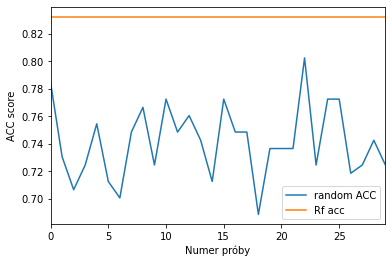

In [112]:
df = pd.DataFrame(list(zip(random_scores_acc, rf_score_acc)), 
               columns =['random ACC', 'Rf acc'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("ACC score")
plot

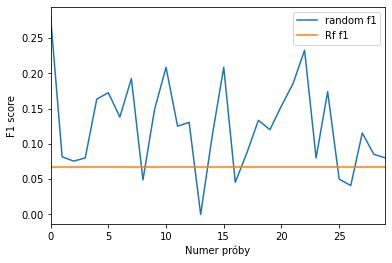

In [113]:
df = pd.DataFrame(list(zip(random_scores_f1, rf_score_f1)), 
               columns =['random f1', 'Rf f1'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("F1 score")
plot

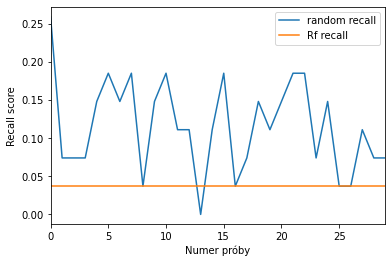

In [114]:
df = pd.DataFrame(list(zip(random_scores_recall, rf_score_recall)), 
               columns =['random recall', 'Rf recall'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("Recall score")
plot

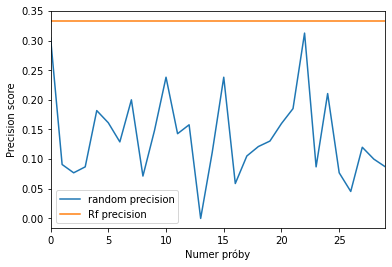

In [115]:
df = pd.DataFrame(list(zip(random_scores_prec, rf_score_prec)), 
               columns =['random precision', 'Rf precision'])

plot = df.plot.line()
plot.set_xlabel("Numer próby")
plot.set_ylabel("Precision score")
plot